In [1]:
import pandas as pd # for dataframes
import numpy as np # for math
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
from sklearn.metrics import mean_squared_error

import xgboost as xgb # What is xgboost? 
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

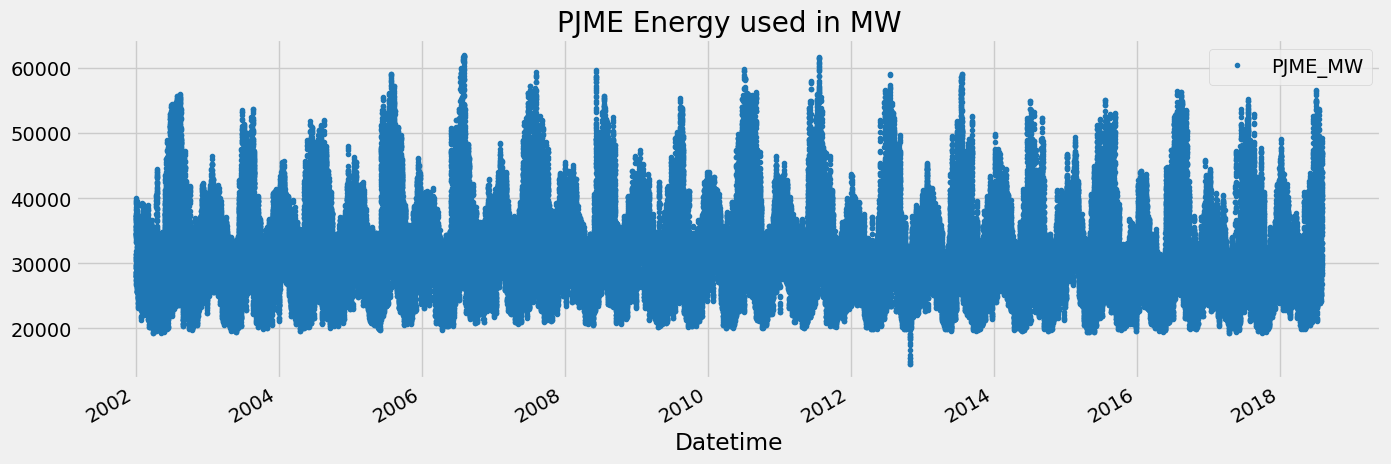

In [2]:
df = pd.read_csv('C:\Code\Energy-Consumption-Forecast\PJME_hourly.csv')
df = df.set_index('Datetime')
df = df.sort_index()
df.index = pd.to_datetime(df.index)

df.plot(style = '.' , 
        figsize = (15,5), 
        color = color_pal[0], 
        title = 'PJME Energy used in MW' )
plt.show()

Graph Title: PJME Energy Use in MW

Purpose: This graph shows the energy consumption in megawatts (MW) over a period from 2002 to 2018.

X-Axis (Datetime): Represents the timeline from 2002 to 2018.
Y-Axis (PJME_MW): Shows the energy usage in megawatts.

Trend: The data displays a cyclical pattern, with regular peaks and troughs, indicating seasonal fluctuations in energy use.

Seasonality: High energy usage during certain periods, likely corresponding to seasonal demands (e.g., higher in summer and winter due to heating and cooling needs).

Observations: Overall, there is a noticeable pattern of increase and decrease, with some years showing higher peaks, suggesting increased energy consumption during those periods.


# Train / Test Split 


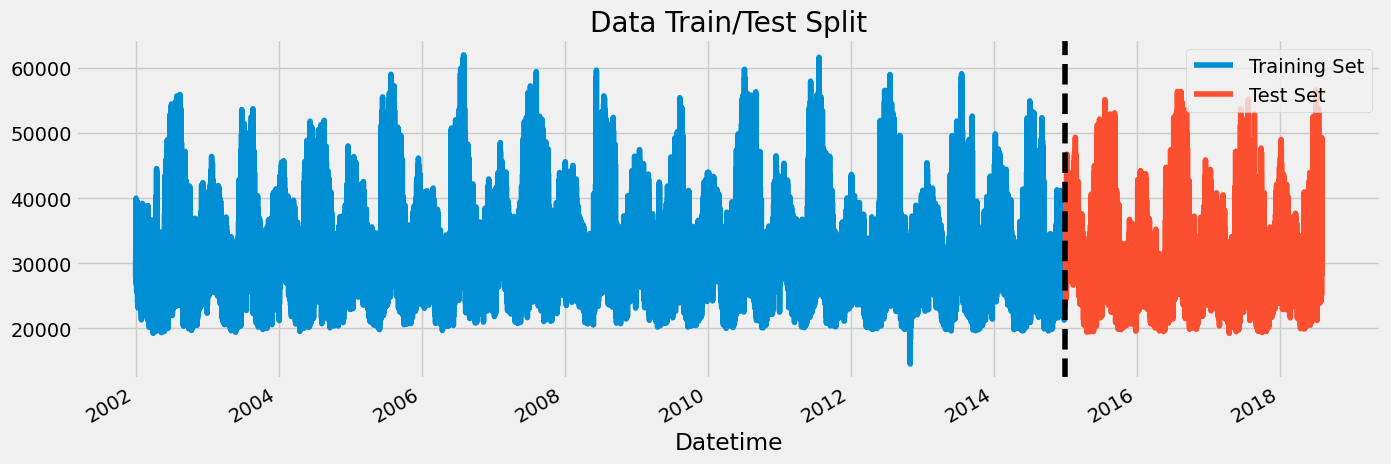

In [3]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Graph Title: Data Train/Test Split

Purpose: Illustrates how the data is divided into training and test sets for model evaluation.

X-Axis (Datetime): Represents the timeline from 2002 to 2018.
Y-Axis (PJME_MW): Shows the energy usage in megawatts.

Training Set (Blue):
Period: From 2002 to 2015
Usage: Used to train the machine learning model.

Test Set (Red):
Period: From 2016 to 2018
Usage: Used to evaluate the model's performance on unseen data.
Observations:

Consistency: Both training and test sets display similar seasonal patterns and trends, ensuring the model can generalize well.
Separation: A clear visual separation (black dashed line) helps in understanding the division of data.

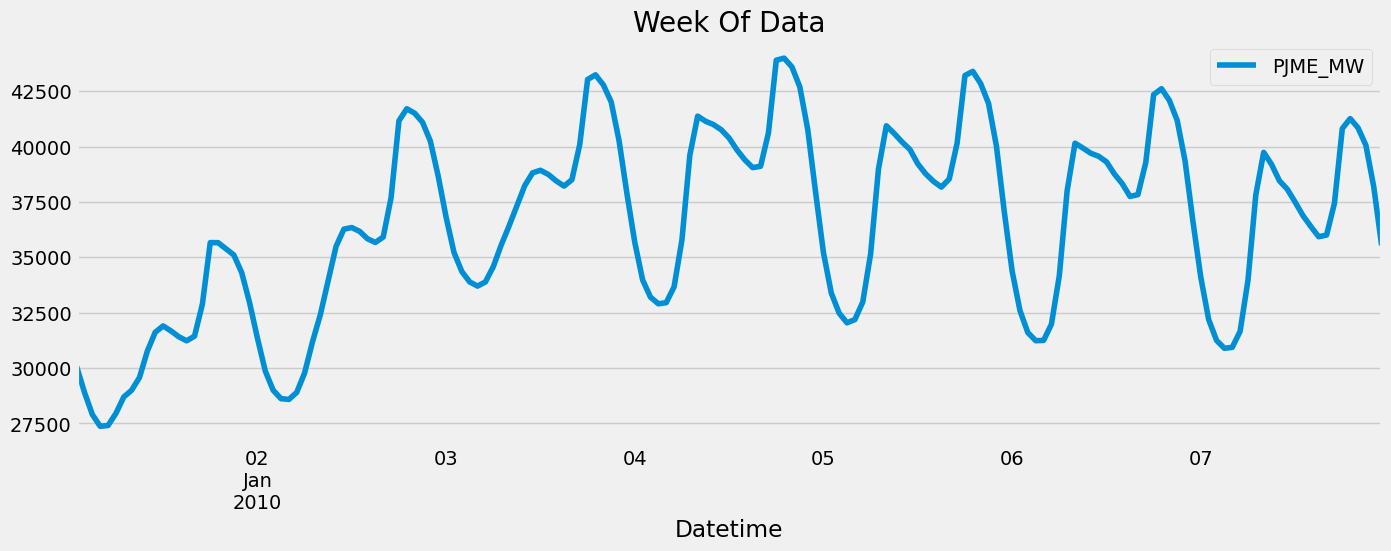

In [4]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


Graph Title: Week Of Data

Purpose: Displays the energy consumption in megawatts (MW) over a one-week period in January 2010.

X-Axis (Datetime): Represents the dates from January 1, 2010, to January 8, 2010.
Y-Axis (PJME_MW): Shows the energy usage in megawatts.

Trend: The data exhibits daily cycles with regular peaks and troughs, indicating a recurring daily pattern of energy use.

Seasonality: Daily peaks likely correspond to higher energy demand during certain times of the day, possibly related to human activities such as work hours.

In [5]:
# Feature Creation 

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


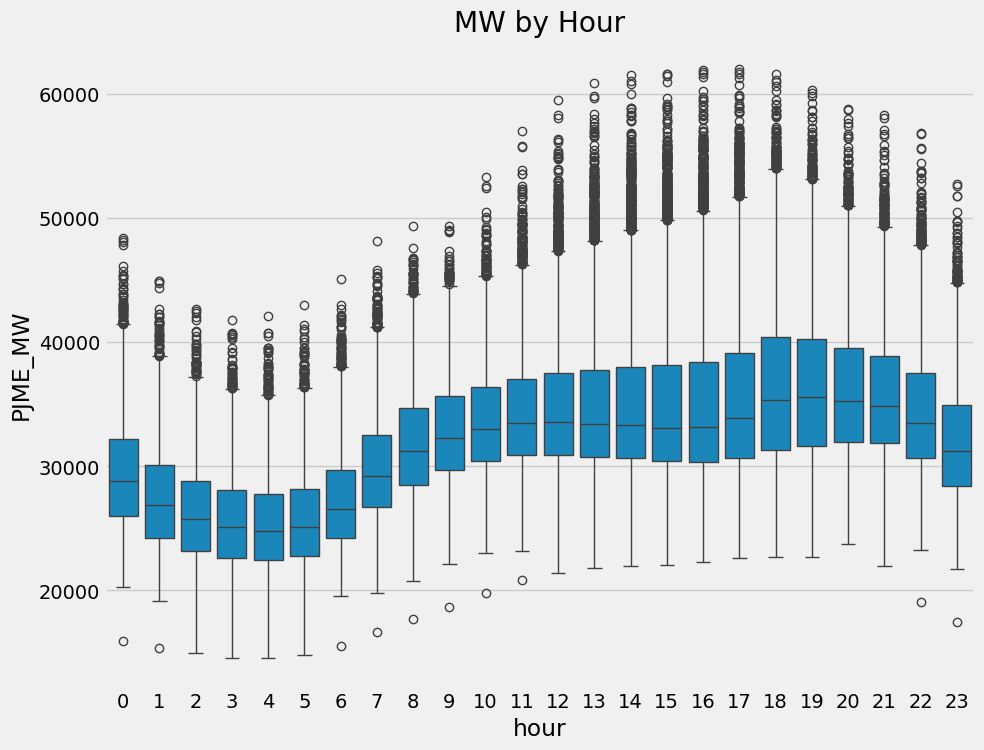

In [6]:
# Visualize our Feature / Target Relationship

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

Graph Title: MW by Hour

Purpose: Shows the distribution of energy consumption in megawatts (MW) for each hour of the day.

X-Axis (hour): Represents each hour of the day from 0 to 23.
Y-Axis (PJME_MW): Displays the energy usage in megawatts.

Description:
Boxes: Represent the interquartile range (IQR) between the 25th and 75th percentiles.
Whiskers: Extend to 1.5 times the IQR, showing the range of the data.
Median: The line within each box represents the median energy usage.
Outliers: Points outside the whiskers are considered outliers.

Observations:
Daily Pattern: Energy usage is lower during the early morning hours (0-6) and increases during the day, peaking around noon to early evening (12-18).
Peak Hours: Highest median usage is observed in the late afternoon to early evening.
Variability: Higher variability and more outliers are observed during peak hours.

C:\Users\mathe\AppData\Local\Temp\ipykernel_26396\2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


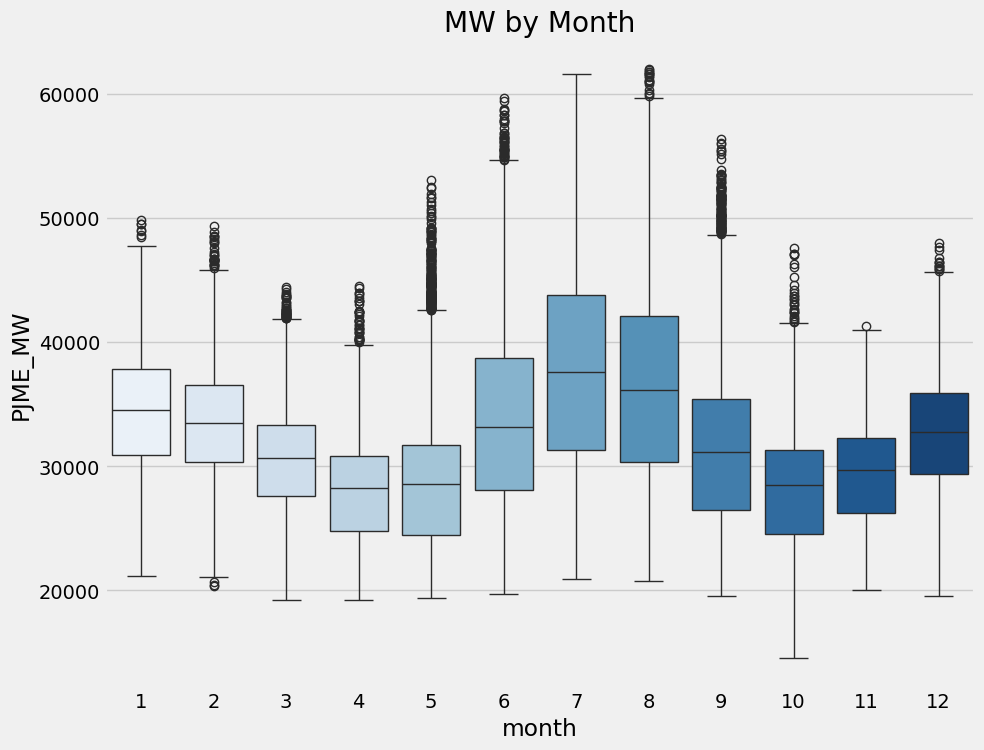

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

Graph Title: MW by Month

Purpose: Shows the distribution of energy consumption in megawatts (MW) for each month of the year.

Seasonal Pattern: Higher energy usage in summer (June, July, August) and winter (January, December) months.
Lower Usage: Lower median usage during the spring (March, April, May) and fall (September, October).
Variability: Greater variability in summer months, indicating more fluctuation in energy demand.

In [8]:
# Model Creation
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',  
                       n_estimators=1000, # Number of boosted trees to fit.
                       early_stopping_rounds=50, # Use early stopping to stop fitting
                       objective='reg:linear', 
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100) # Prints every 100 trees

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\mathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [21:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

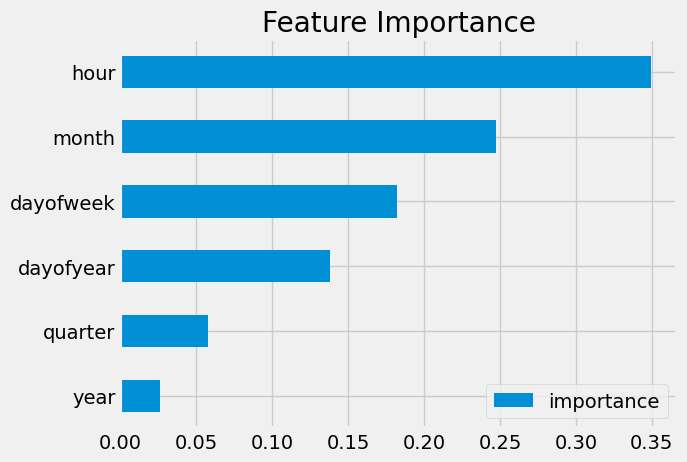

In [9]:
# Feature Importance

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Graph Title: Feature Importance

Purpose: Illustrates the importance of different features in predicting energy usage.

X-Axis: Importance score (ranging from 0 to 0.35).
Y-Axis: Different time-based features (month, hour, day of the week, etc.).

Description:
Features: Includes month, hour, day of the week, day of the year, quarter, and year.
Importance Scores: Indicates the relative importance of each feature in the prediction model.
Highest Importance: Month has the highest importance, followed by hour, and day of the week.
Least Importance: Year has the lowest importance.

Observations:
Month and Hour: Key indicators of energy usage patterns.
Lower Impact: Features like the year and quarter contribute less to the prediction accuracy.

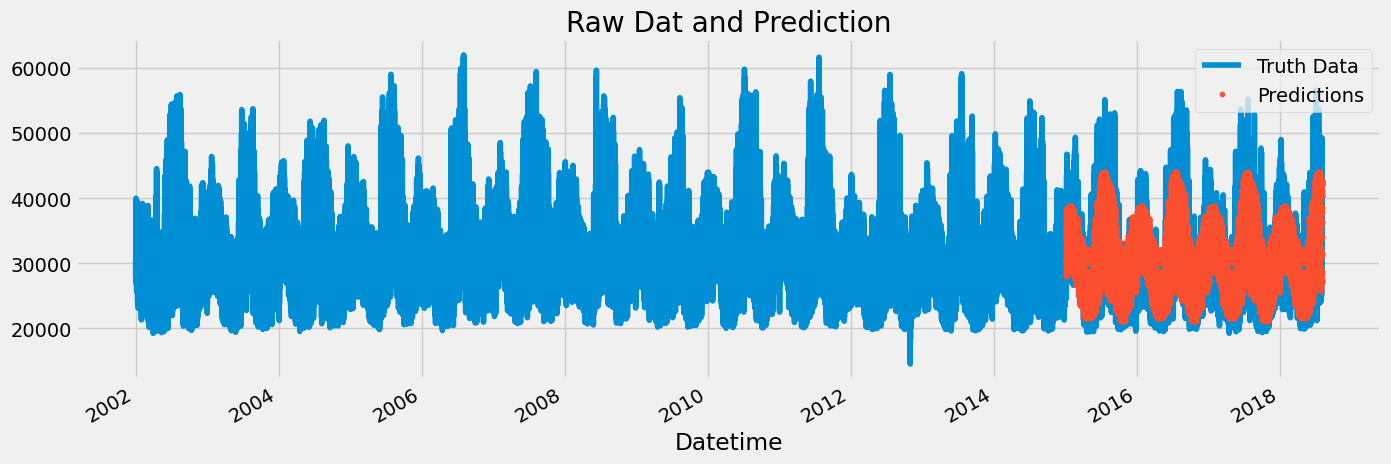

In [10]:
# Forecast on Test Set
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

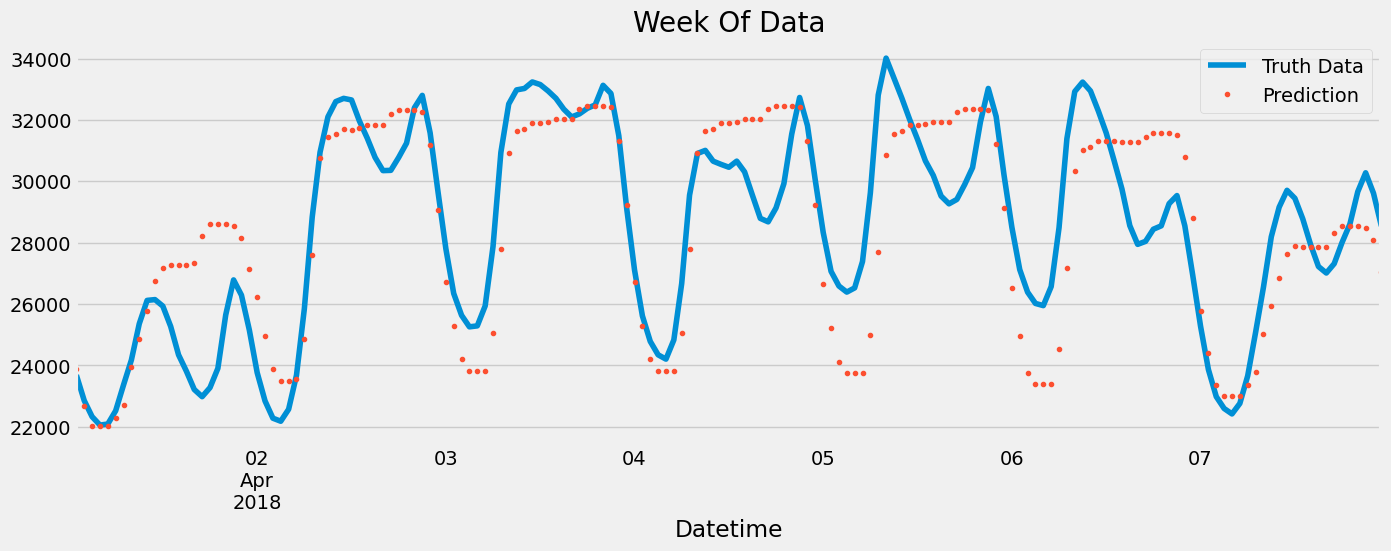

In [11]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Graph Title: Week Of Data

Purpose: Compares the actual energy consumption data to the predicted values over a week in April 2018.

X-Axis (Datetime): Represents the dates from April 1, 2018, to April 7, 2018.
Y-Axis (PJME_MW): Shows the energy usage in megawatts.

Data Series:
Truth Data (Blue Line): Represents the actual measured energy consumption.
Prediction (Red Dots): Represents the predicted energy consumption values from the model.

Observations:
Accuracy: The predicted values generally follow the trend of the actual data, capturing the peaks and troughs.
Deviation: Some discrepancies between the actual and predicted values are observed, indicating areas where the model's predictions could be improved.

This model is not perfect. 
Improvement to be made: 
Parameter tuning. 
Consider holidays and weather forecast. 

In [12]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [13]:
# Calculate Errors 

test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
Name: error, dtype: float64